# Inspecting relation between energy, influent flow and demand.

In [48]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
from fuzzywuzzy import fuzz, process
import unidecode

In [49]:
#This function adds date information like year, month, week, etc. 
def add_date_data(DF):
    DF_dates=pd.DataFrame({'date':DF.date.unique(),'year':0,
                          'month':0,'month_day':0,
                          'year_day':0,'weekday':0,
                          'week':0})

    for ind in DF_dates.index:
        date=DF_dates.date[ind]
        date_st=date.timetuple()
        DF_dates.loc[ind,'year']=date_st.tm_year
        DF_dates.loc[ind,'month']=date_st.tm_mon
        DF_dates.loc[ind,'month_day']=date_st.tm_mday
        DF_dates.loc[ind,'year_day']=date_st.tm_yday
        DF_dates.loc[ind,'weekday']=date_st.tm_wday
        DF_dates.loc[ind,'week']=date.isocalendar()[1]
        
        
    DF=DF.merge(DF_dates, on='date')
    return DF

def fix_dam_name(x):
    return unidecode.unidecode(x.strip())

In [50]:
#Load energy dataframe
DF_energy=pd.read_csv('../../Data/subsystem_all_dams/Energy_generated_daily_by_dam.csv.zip')
DF_energy['date']=pd.to_datetime(DF_energy.date)
DF_energy['dam']=DF_energy.dam.apply(fix_dam_name)

#Add missing date
DF=DF_energy.groupby('dam').mean().reset_index()
DF['date']=pd.to_datetime('2014-02-01')
DF_energy=pd.concat([DF_energy,DF],axis=0)

In [51]:
#Load influent flow dataframe
DF_flow=pd.read_csv('../../Data/subsystem_all_dams/Influent_flow_daily_by_dam.csv.zip')
DF_flow['date']=pd.to_datetime(DF_flow.date)
DF_flow['dam']=DF_flow.dam.apply(fix_dam_name)

In [52]:
#load demand dataframe
DF_Demand=pd.read_csv('../../Data/Maximum_Demand_SSDaily.csv')
DF_Demand.columns=['date','maximum_demand']
DF_Demand.loc[len(DF_Demand)+1]=['2014-02-01', 
                np.mean(DF_Demand.maximum_demand[(DF_Demand.date=='2014-01-31')|(DF_Demand.date=='2014-02-02')])]
DF_Demand.date=pd.to_datetime(DF_Demand.date)

# Combine Flow and Energy
We combine the Influent Flow and the Energy Generated (and demand) for the most important dams. 
(As chosen by ONS, including also ITAIPU). 

In [53]:
#Names of the dams in the dataframes
A=DF_flow.dam.unique()
B=DF_energy.dam.unique()

In [54]:
#Find the corresponding name of the dam for the most important dams. 
Important_Dams=['M. MORAES', 'FURNAS', 'A. VERMELHA', 'MARIMBONDO', 
                 'PARAIBUNA', 'I. SOLTEIRA', 'BATALHA', 'SERRA DO FACAO',
                 'SAO SIMAO', 'EMBORCACAO', 'NOVA PONTE', 'ITUMBIARA',
                 'CAPIVARA', 'JURUMIRIM', 'CHAVANTES', 'TRES MARIAS',
                 'BILLINGS', 'B. BONITA', 'TRES IRMAOS', 'SERRA DA MESA',
                 'ITAIPU']
A=[process.extractOne(a,A)[0] for a in Important_Dams] #Doing this because we checked there is a corresponding one for each. 

In [55]:
#Match names
Name_matching=pd.DataFrame({'dam_flow':A,'dam_energy':'', 'score':0, 'others':''})
for ind in Name_matching.index:
    a=Name_matching.loc[ind,'dam_flow']
    matches=process.extractBests(a,B)
    b,score=matches[0]
    Name_matching.loc[ind,['dam_energy','score']]=[b,score]
    if score<100:
        Name_matching.loc[ind,'others']=' | '.join([m[0] for m in matches[1:]])
with pd.option_context('display.max_colwidth', -1):
    display(Name_matching.sort_values('score', ascending=False))

dam_flow                   dam_energy  score  \
10  NOVA PONTE     NOVA PONTE                   100     
9   EMBORCACAO     EMBORCACAO                   100     
19  SERRA DA MESA  SERRA DA MESA                100     
18  TRES IRMAOS    TRES IRMAOS                  100     
15  TRES MARIAS    TRES MARIAS                  100     
14  CHAVANTES      CHAVANTES                    100     
1   FURNAS         FURNAS                       100     
20  ITAIPU         ITAIPU                       100     
6   BATALHA        BATALHA                      100     
4   PARAIBUNA      PARAIBUNA                    100     
3   MARIMBONDO     MARIMBONDO                   100     
8   SAO SIMAO      SAO SIMAO (CEMIG)            90      
11  ITUMBIARA      ITUMBIARA (FURNAS)           90      
7   S.DO FACAO     SALTO DO RIO VERDINHO        86      
5   I. SOLTEIRA    CORUMBA I (FURNAS)           86      
2   A. VERMELHA    FONTES NOVA (A+BC+SC)        86      
0   M. MORAES      SEN. JOSE ERMIRIO DE MORAES  86      
17  B. BONITA      BARRA BONITA                 82      
12  CAPIVARA       IRARA                        72      
13  JURUMIRIM      JAURU                        72      
16  BILLINGS       IBITINGA                     62      

                                                                                                others  
10                                                                                                      
9                                                                                                       
19                                                                                                      
18                                                                                                      
15                                                                                                      
14                                                                                                      
1                                                                                                       
20                                                                                                      
6                                                                                                       
4                                                                                                       
3                                                                                                       
8   SAO JOAQUIM (ACEP) | SAO LOURENCO (ACEP) | SAO DOMINGOS (ELETROSUL) | SAO MANOEL                    
11  IRARA | ITIQUIRA I + ITIQUIRA II | JIRAU | ITUTINGA                                                 
7   SANTO ANTONIO DO CAIAPO | CONJUNTO HIDRAULICO COMPLEXO DO PRATA | BARRA DO BRAUNA | SERRA DO FACAO  
5   COMPLEXO ILHA SOLTEIRA | Juba I | ITIQUIRA I + ITIQUIRA II | IRAPE                                  
2   SALTO (RVESA) | ENG. JOSE GELASIO DA ROCHA | SERRA DA MESA | ESCOLA ENGENHARIA ALEXANDRE MACKENZIE  
0   MAL. MASCARENHAS DE MORAES | AIMORES | SAO JOAQUIM (ACEP) | IRAPE                                   
17  ITAIPU | FONTES NOVA (A+BC+SC) | SANTO ANTONIO (STO. ANTONIO) | BARRA DO BRAUNA                     
12  PCH IACIARA | PIRAJU | IRAPE | JIRAU                                                                
13  JIRAU | SEN. JOSE ERMIRIO DE MORAES | CORUMBA III | Juba II                                         
16  ITUTINGA | SAO DOMINGOS (ELETROSUL) | SALTO BURITI | SANTA GABRIELA

In [56]:
#We notice that when the score is >=90, the match is done correctly. 
Names_dict={Name_matching.dam_flow[ind]:Name_matching.dam_energy[ind] for\
            ind in Name_matching.index if Name_matching.score[ind]>=90}

#Manually choose best matching names for the dams in both dataframes for the remaining cases
Names_dict['S.DO FACAO']='SERRA DO FACAO'
Names_dict['I. SOLTEIRA']='COMPLEXO ILHA SOLTEIRA'
Names_dict['A. VERMELHA']='SEN. JOSE ERMIRIO DE MORAES' 
Names_dict['M. MORAES']='MAL. MASCARENHAS DE MORAES'
Names_dict['B. BONITA']='BARRA BONITA'
Name_matching=pd.DataFrame({'dam_flow':Names_dict.keys(), 'dam_energy':[Names_dict[k] for k in Names_dict.keys()]})

In [57]:
#Add basins information (from ONS webpage)
basins=['GRANDE',
 'GRANDE',
 'PARAIBO DO SUL',
 'PARANAIBA',
 'PARANAIBA',
 'PARANAIBA',
 'PARANAIBA',
 'PARANAIBA',
 'PARANAPANEMA',
 'SAO FRANCISCO',
 'TIETE',
 'TOCANTINS',
 'PARANA',
 'PARANAIBA',
 'PARANA',
 'GRANDE',
 'GRANDE',
 'TIETE']
Name_matching['basin']=basins
Name_matching.groupby(['basin','dam_energy']).count().drop('dam_flow',axis=1)

Empty DataFrame
Columns: []
Index: [(GRANDE, FURNAS), (GRANDE, MAL. MASCARENHAS DE MORAES), (GRANDE, MARIMBONDO), (GRANDE, SEN. JOSE ERMIRIO DE MORAES), (PARAIBO DO SUL, PARAIBUNA), (PARANA, COMPLEXO ILHA SOLTEIRA), (PARANA, ITAIPU), (PARANAIBA, BATALHA), (PARANAIBA, EMBORCACAO), (PARANAIBA, ITUMBIARA (FURNAS)), (PARANAIBA, NOVA PONTE), (PARANAIBA, SAO SIMAO (CEMIG)), (PARANAIBA, SERRA DO FACAO), (PARANAPANEMA, CHAVANTES), (SAO FRANCISCO, TRES MARIAS), (TIETE, BARRA BONITA), (TIETE, TRES IRMAOS), (TOCANTINS, SERRA DA MESA)]

In [58]:
#Create a Dataframe Including everything
All_DF=DF_flow.merge(Name_matching,how='inner',left_on='dam', right_on='dam_flow').drop('dam',axis=1)
All_DF=All_DF.merge(DF_energy, how='inner',left_on=['date','dam_energy'], right_on=['date','dam']).drop('dam',axis=1)

In [63]:
#Also create a pivot for easier use.
DF=All_DF.copy()
DF=add_date_data(DF)
DF['dam']=DF['dam_energy']
DF=DF.groupby(['year','month','dam']).agg(influent_flow=('influent_flow','mean')).reset_index()
DF['date']=pd.to_datetime((DF.year*10000+DF.month*100+1).apply(str),format='%Y%m%d')
DF=DF[['date','dam','influent_flow']]
DF=DF.pivot(index='date',columns='dam',values='influent_flow').reset_index()
DF.to_csv('../../Data/subsystem_all_dams/Mean_Influent_Flow_per_Important_Dam.csv',index=False)

In [13]:
All_DF=All_DF.merge(DF_Demand,on='date')
All_DF=add_date_data(All_DF)

#Add a column called 'dam' for a common name of the dam
All_DF['dam']=All_DF['dam_energy']

In [14]:
#Now we  aggregate Monthly
All_DF_monthly=All_DF.groupby(['year','month','dam']).\
            agg(date=('date','min'),
            energy_generated=('energy_generated','sum'),
            influent_flow=('influent_flow','mean'),
            dam_flow=('dam_flow',lambda x: ' & '.join([str(a) for a in x.unique()])),
            maximum_demand=('maximum_demand','sum')).reset_index()
All_DF_monthly

year  month                          dam       date  energy_generated  \
0     2000      1                 BARRA BONITA 2000-01-01         42.058100   
1     2000      1                    CHAVANTES 2000-01-01        176.063700   
2     2000      1       COMPLEXO ILHA SOLTEIRA 2000-01-01       1291.327700   
3     2000      1                   EMBORCACAO 2000-01-01        215.318400   
4     2000      1                       FURNAS 2000-01-01        493.535600   
...    ...    ...                          ...        ...               ...   
4239  2020     12  SEN. JOSE ERMIRIO DE MORAES 2020-12-01        457.492881   
4240  2020     12                SERRA DA MESA 2020-12-01        515.553659   
4241  2020     12               SERRA DO FACAO 2020-12-01         61.537397   
4242  2020     12                  TRES IRMAOS 2020-12-01        103.632492   
4243  2020     12                  TRES MARIAS 2020-12-01        223.273799   

      influent_flow       dam_flow  maximum_demand  
0        578.978710      B. BONITA      901759.000  
1        256.261290      CHAVANTES      901759.000  
2       5392.369355    I. SOLTEIRA      901759.000  
3        693.645161     EMBORCACAO      901759.000  
4       2177.839355         FURNAS      901759.000  
...             ...            ...             ...  
4239    1677.959681    A. VERMELHA     1384994.594  
4240     374.516131  SERRA DA MESA     1384994.594  
4241      64.576451     S.DO FACAO     1384994.594  
4242     639.568061    TRES IRMAOS     1384994.594  
4243     571.686451    TRES MARIAS     1384994.594  

[4244 rows x 8 columns]

In [15]:
All_DF['log_flow']=np.log(All_DF.influent_flow)
All_DF_monthly['log_flow']=np.log(All_DF_monthly.influent_flow)

C:\Users\Francisco\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
All_DF_monthly.to_csv('../../Data/subsystem_all_dams/Selected_important_dams_energy_demand_flow_monthly.csv.zip',index=False)

In [17]:
#Save the data
All_DF.to_csv('../../Data/subsystem_all_dams/Selected_important_dams_energy_demand_flow.csv.zip',index=False)

# Create some plots
## First focus on the "Most important dams"

In [18]:
#import ggplot
from plotnine import *
from datetime import date
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [19]:
#Add date to individual dataframes
DF_energy=add_date_data(DF_energy)
DF_flow=add_date_data(DF_flow)
DF_Demand=add_date_data(DF_Demand)

In [20]:
#Compute correlations for the "important dams"
Corr_DF=pd.DataFrame({'dam':All_DF.dam.unique(),'corr_energy':0,'corr_demand':0})
for ind in Corr_DF.index:
    dam=Corr_DF.loc[ind,'dam']
    DF=All_DF_monthly[All_DF_monthly.dam==dam]
    Corr_DF.loc[ind,'corr_energy']=np.corrcoef(DF.energy_generated, DF.influent_flow)[0,1]
    Corr_DF.loc[ind,'corr_demand']=np.corrcoef(DF.energy_generated, DF.maximum_demand)[0,1]

In [21]:
Corr_DF.sort_values('corr_energy', ascending=False).tail(10)

dam  corr_energy  corr_demand
9               ITAIPU     0.387535     0.023763
8   ITUMBIARA (FURNAS)     0.363600    -0.045359
16      SERRA DO FACAO     0.344215     0.151255
0          TRES MARIAS     0.276756    -0.275011
11              FURNAS     0.102763     0.013286
12          EMBORCACAO     0.024392    -0.071387
17             BATALHA    -0.052373     0.077298
5           NOVA PONTE    -0.055549     0.033132
4            PARAIBUNA    -0.224389     0.056673
2        SERRA DA MESA    -0.225603    -0.164421

In [22]:
Corr_DF_daily=pd.DataFrame({'dam':All_DF.dam.unique(),'corr_energy':0,'corr_demand':0})
for ind in Corr_DF.index:
    dam=Corr_DF.loc[ind,'dam']
    DF=All_DF[All_DF.dam==dam]
    Corr_DF_daily.loc[ind,'corr_energy']=np.corrcoef(DF.energy_generated, DF.log_flow)[0,1]
    Corr_DF_daily.loc[ind,'corr_demand']=np.corrcoef(DF.energy_generated, DF.maximum_demand)[0,1]

In [23]:
Corr_DF_daily.sort_values('corr_energy',ascending=False)

dam  corr_energy  corr_demand
10       COMPLEXO ILHA SOLTEIRA     0.770275     0.048280
7    MAL. MASCARENHAS DE MORAES     0.753567     0.002973
15  SEN. JOSE ERMIRIO DE MORAES     0.721641     0.109294
6                    MARIMBONDO     0.658581     0.103931
3             SAO SIMAO (CEMIG)     0.632617     0.048596
14                 BARRA BONITA     0.591661     0.046434
13                    CHAVANTES     0.559411     0.112100
1                   TRES IRMAOS     0.513500     0.193888
8            ITUMBIARA (FURNAS)     0.404014     0.117405
9                        ITAIPU     0.391002     0.108620
16               SERRA DO FACAO     0.293692     0.218287
11                       FURNAS     0.076775     0.119574
12                   EMBORCACAO     0.052414     0.019800
17                      BATALHA    -0.041662     0.076860
5                    NOVA PONTE    -0.099508     0.117609
4                     PARAIBUNA    -0.210420     0.022896
0                   TRES MARIAS          NaN    -0.261098
2                 SERRA DA MESA          NaN    -0.101895

C:\Users\Francisco\anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 3 rows containing missing values.


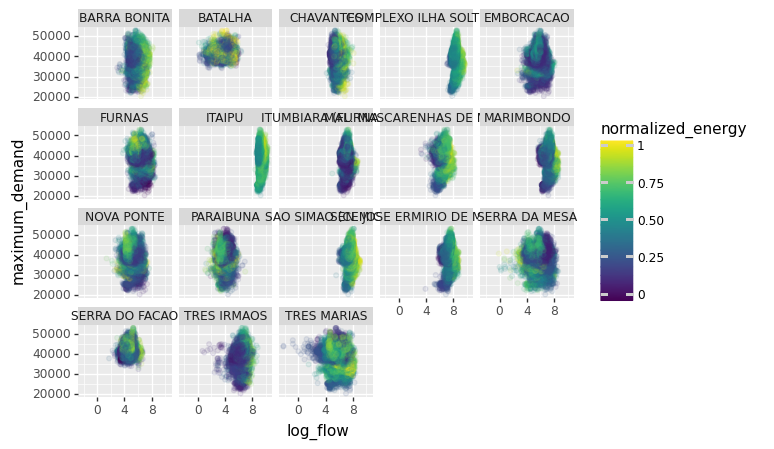

<ggplot: (91894338533)>

In [24]:
#We plot the relation between influent flow and maximum demand per dam
#So that the colors make sense, we normalize the energy generated per dam (divide it by the largest value in each dam)

DF2=All_DF.copy()
DF2['normalized_energy']=All_DF[['dam', 'energy_generated']].\
    groupby('dam',group_keys=False).apply(lambda x: x/x.max())

ggplot(DF2,aes(x='log_flow',y='maximum_demand',color='normalized_energy',group='dam'))+\
geom_point(alpha=0.1)+facet_wrap('dam')

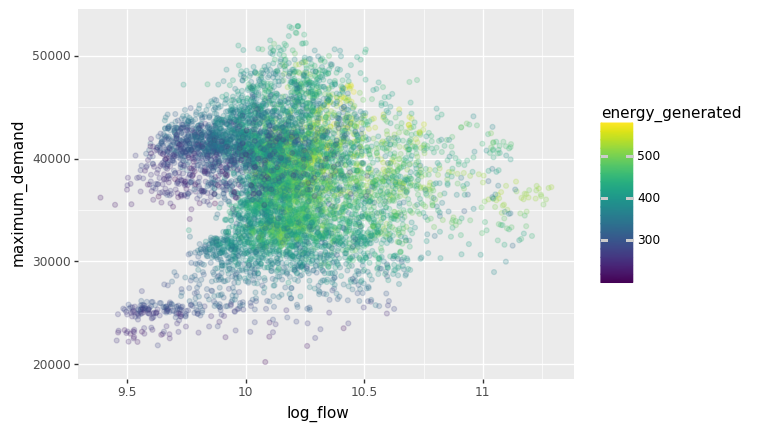

<ggplot: (91908301541)>

In [25]:
#Combine information of the most important Dams
DF=All_DF.groupby(['year','month','date','year_day']).agg(maximum_demand=('maximum_demand','max'),
                                                        influent_flow=('influent_flow','sum'),
                                                        energy_generated=('energy_generated','sum')).reset_index()

DF['log_flow']=np.log(DF.influent_flow)
ggplot(DF,aes(x='log_flow',y='maximum_demand',color='energy_generated'))+\
geom_point(alpha=0.2)

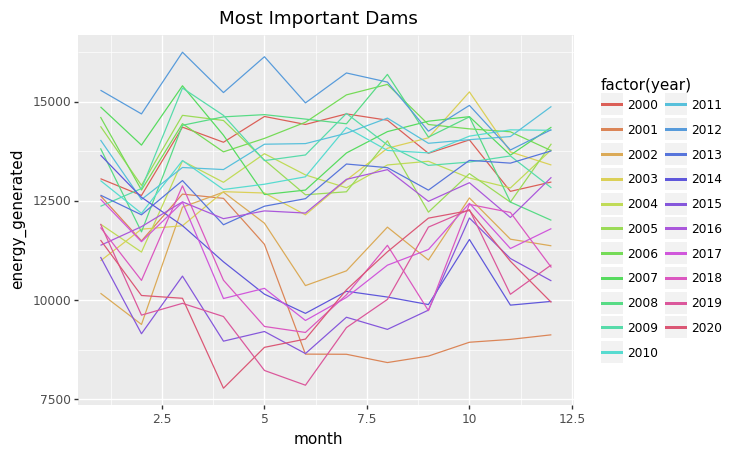

<ggplot: (91915696960)>

In [26]:
#Seasonality of the most important dams
DF=All_DF.groupby(['year','month']).agg(maximum_demand=('maximum_demand','max'),
                                                        influent_flow=('influent_flow','sum'),
                                                        energy_generated=('energy_generated','sum')).reset_index()
ggplot(DF,aes(x='month',y='energy_generated', color='factor(year)'))+\
geom_line()+ggtitle('Most Important Dams')

## Flow and Demand  vs Energy Generated for Barra Bonita

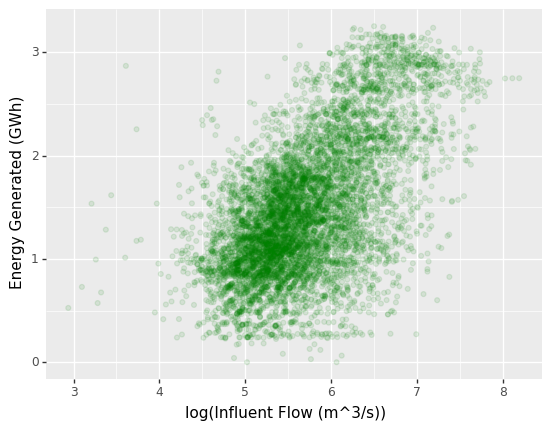

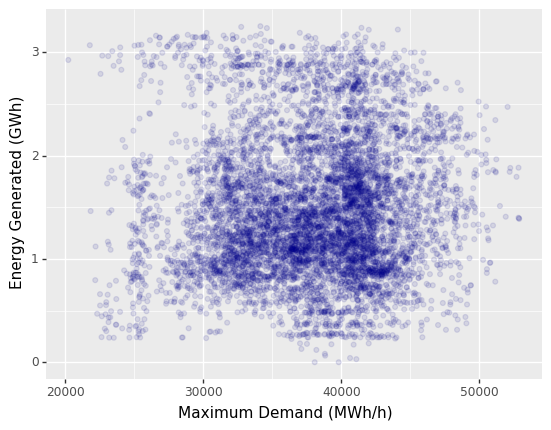

<ggplot: (91919100745)>

In [27]:
#BARRA BONITA
dam='BARRA BONITA'
DF2=All_DF.copy()[All_DF.dam==dam]

G=ggplot(DF2,aes(x='log_flow',y='energy_generated'))+\
geom_point(alpha=0.1,color='green')+xlab('log(Influent Flow (m^3/s))')+ylab('Energy Generated (GWh)')
G.draw()

G=ggplot(DF2,aes(x='maximum_demand',y='energy_generated'))+\
geom_point(alpha=0.1, color='darkblue')+xlab('Maximum Demand (MWh/h)')+ylab('Energy Generated (GWh)')
G

## Energy generated and demand for All Dams in SE/CW

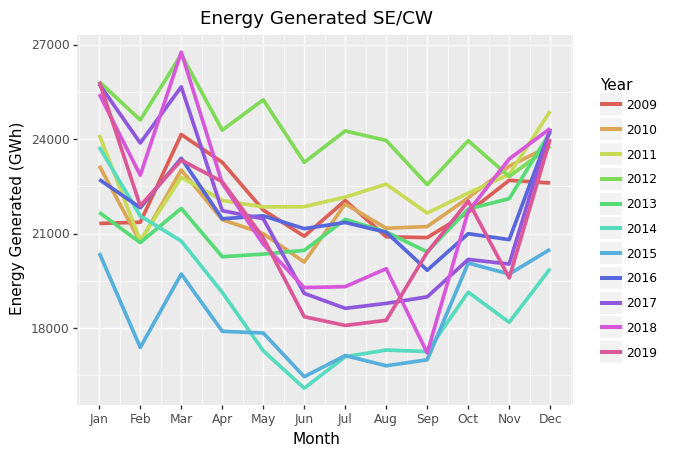

<ggplot: (91919106401)>

In [28]:
#Plot energy generated by year
DF=DF_energy.groupby(['year','month']).agg(date=('date', 'max'), energy_generated=('energy_generated','sum')).reset_index()
DF=DF[(DF.date>='2009-01-01') & (DF.date<='2019-12-31')]

ggplot(DF,aes(x='month',y='energy_generated', color='factor(year)'))+\
 geom_line(size=1.5)+ggtitle('Energy Generated SE/CW')+xlab('Month')+ylab('Energy Generated (GWh)')+\
scale_x_continuous(breaks=range(1,13), 
                   labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep', 'Oct','Nov','Dec'])+\
 scale_color_discrete(name = "Year")

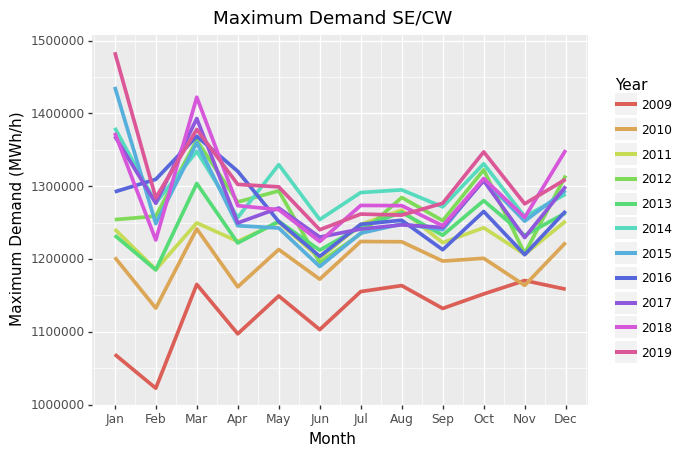

<ggplot: (91922944907)>

In [29]:
#Plot demand by year
DF=DF_Demand.groupby(['year','month']).agg(date=('date', 'max'), maximum_demand=('maximum_demand','sum')).reset_index()
DF=DF[(DF.date>='2009-01-01') & (DF.date<='2019-12-31')]

ggplot(DF,aes(x='month',y='maximum_demand', color='factor(year)'))+\
 geom_line(size=1.5)+ggtitle('Maximum Demand SE/CW')+xlab('Month')+ylab('Maximum Demand (MWh/h)')+\
scale_x_continuous(breaks=range(1,13), 
                   labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep', 'Oct','Nov','Dec'])+\
 scale_color_discrete(name = "Year")

## Energy Generated for the most important dams

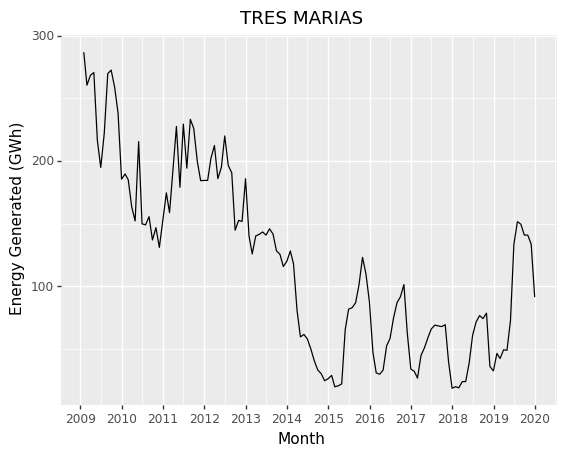

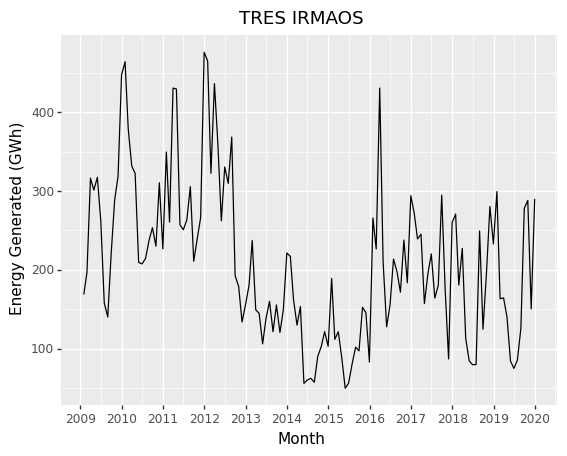

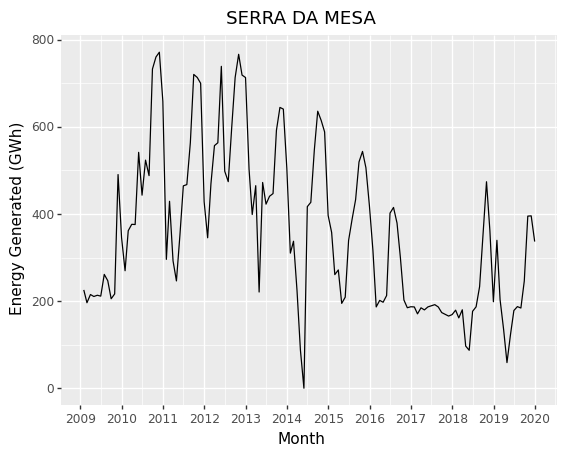

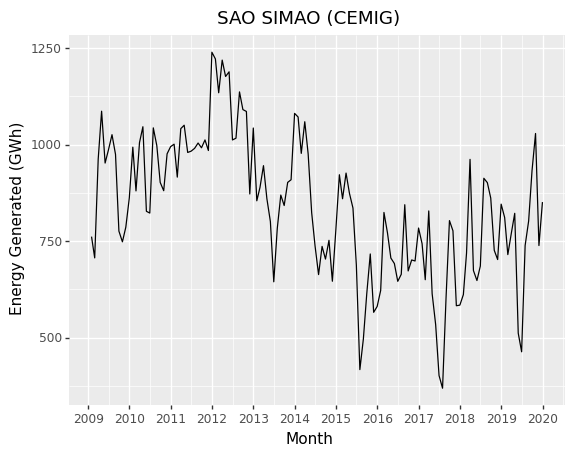

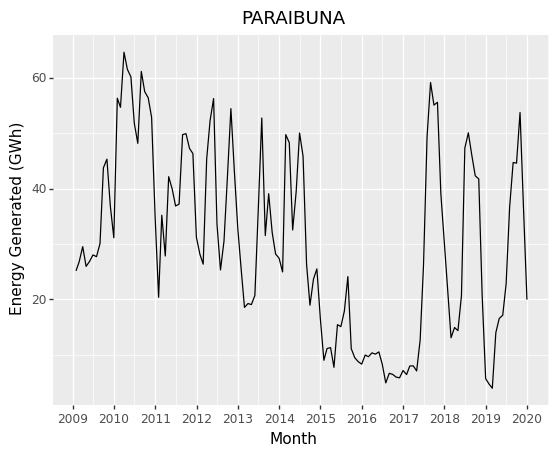

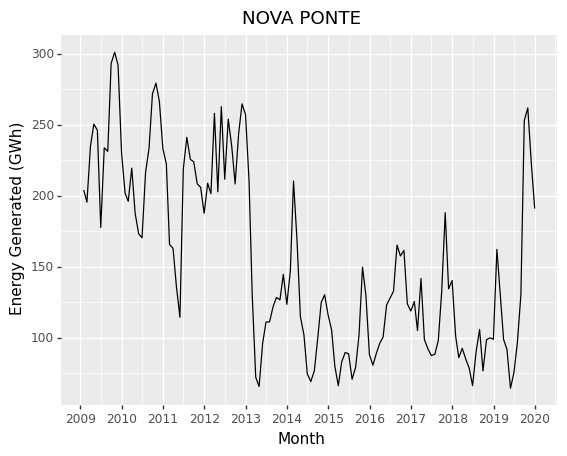

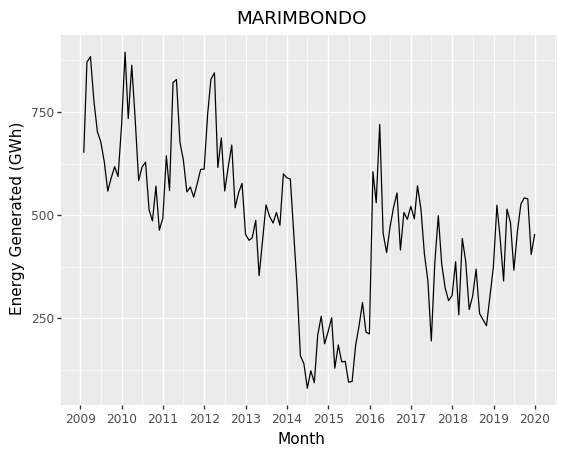

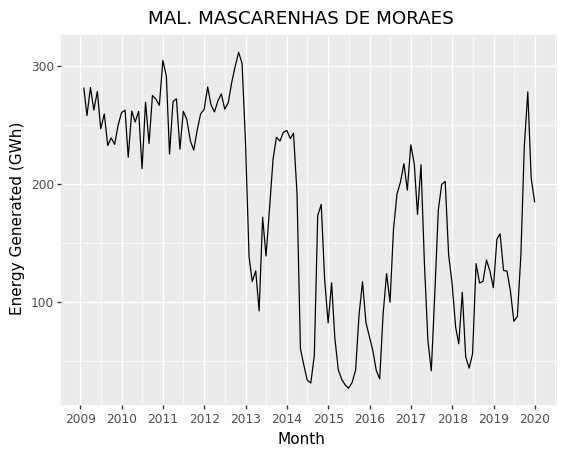

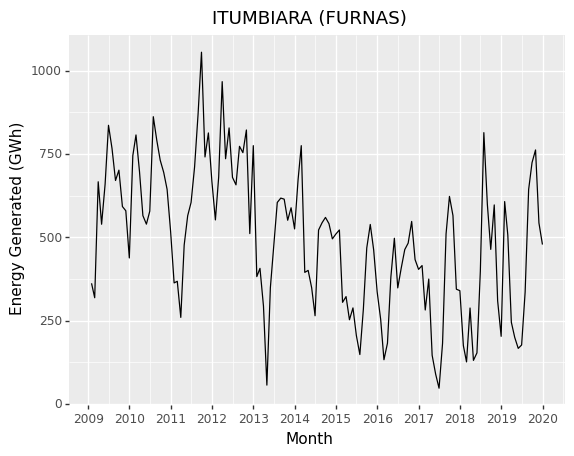

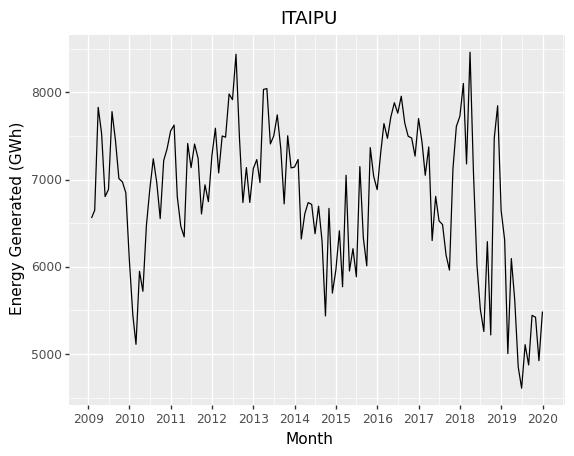

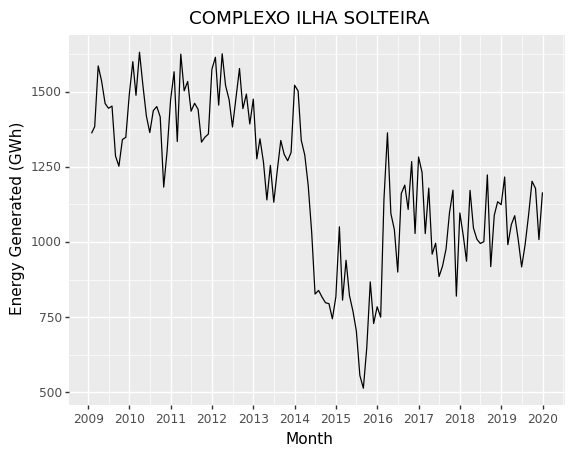

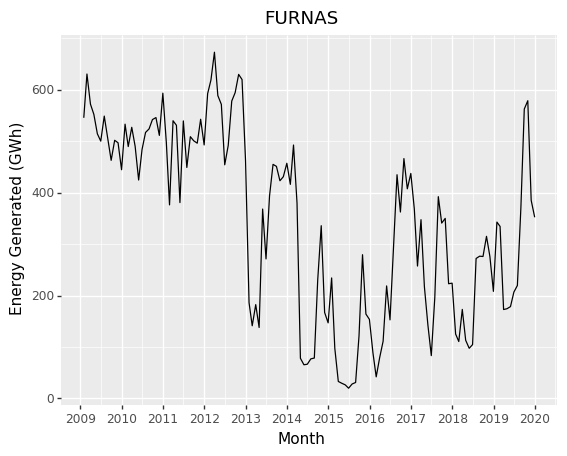

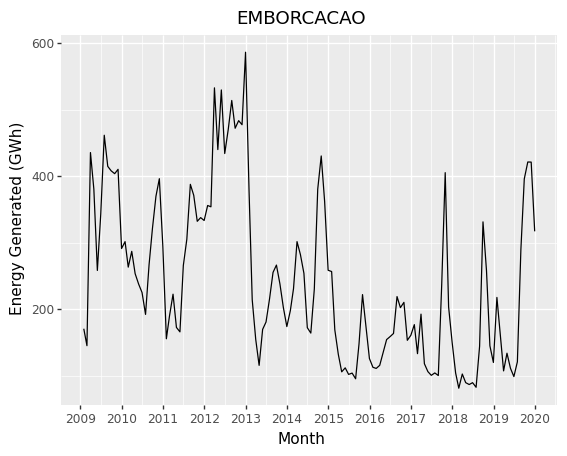

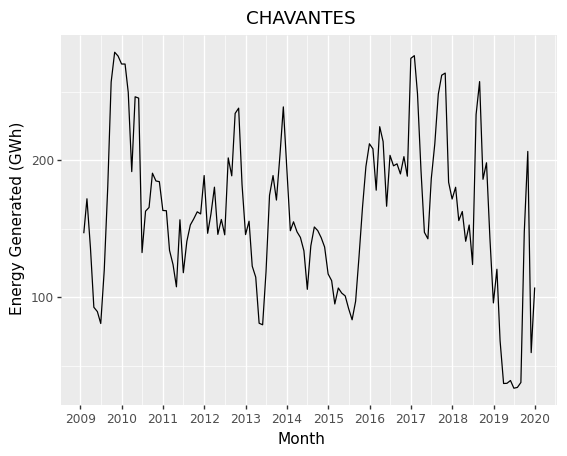

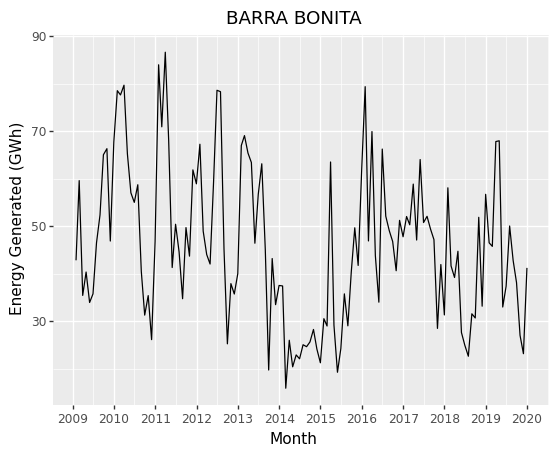

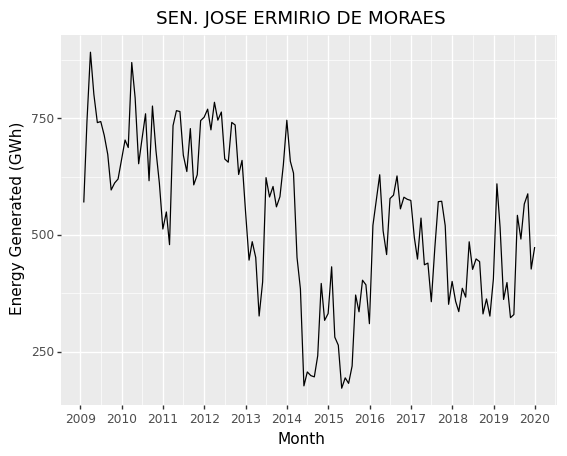

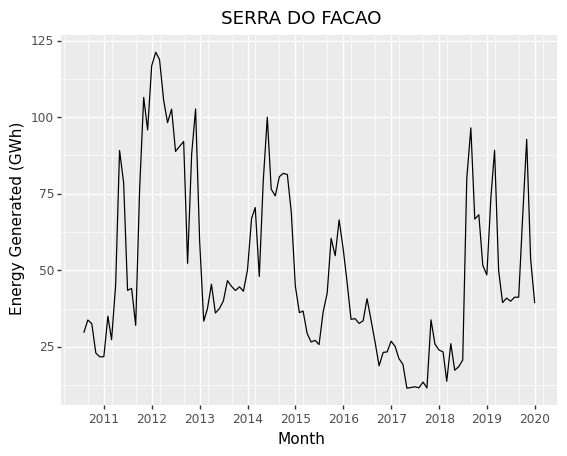

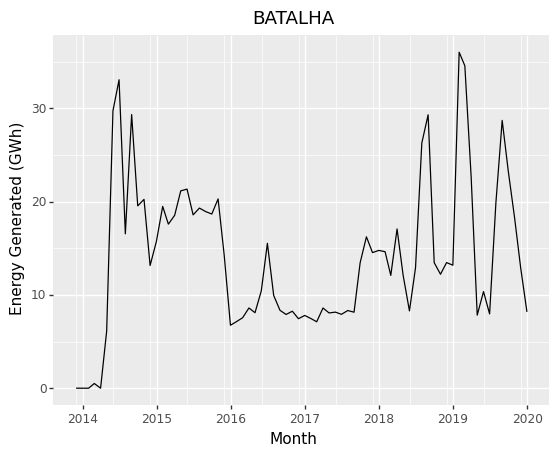

In [30]:
#Plot energy generated per dam between 2009 and 2019 for the most important ones. 
for dam in All_DF.dam.unique():
    DF=All_DF[All_DF.dam==dam].groupby(['year','month']).agg(energy_generated=('energy_generated','sum'),
                                                                        date=('date', 'max')).reset_index()
    DF=DF[(DF.year>=2009) & (DF.year<=2019)]

    G=ggplot(DF,aes(x='date',y='energy_generated', group=1))+\
    geom_line()+ggtitle(dam)+xlab('Month')+ylab('')+\
    scale_x_datetime(breaks=date_breaks('1 years'),
     labels=date_format('%Y'), minor_breaks=date_breaks('6 months'))+\
    ylab('Energy Generated (GWh)')
    G.draw()

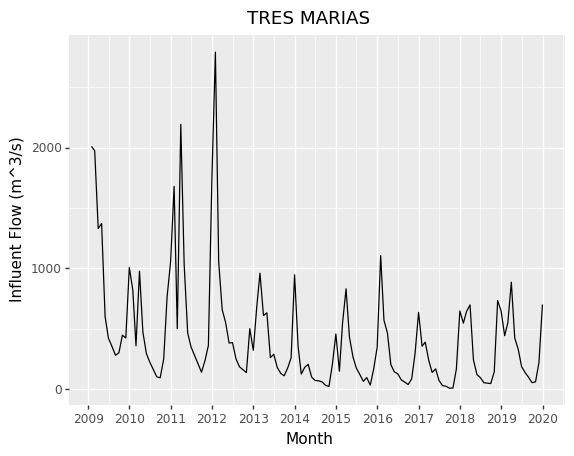

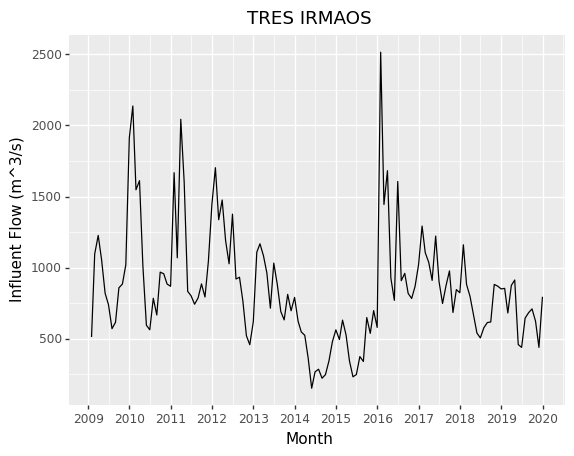

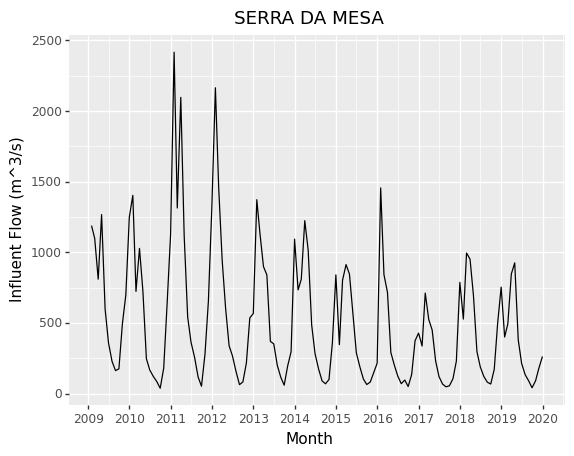

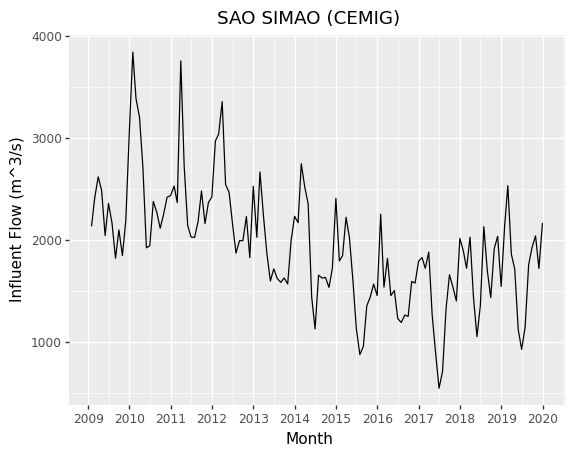

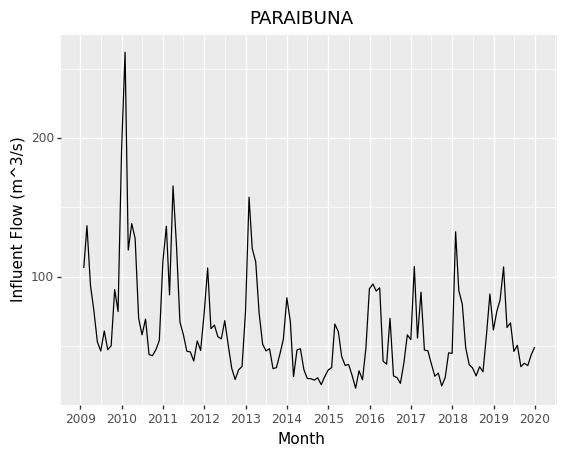

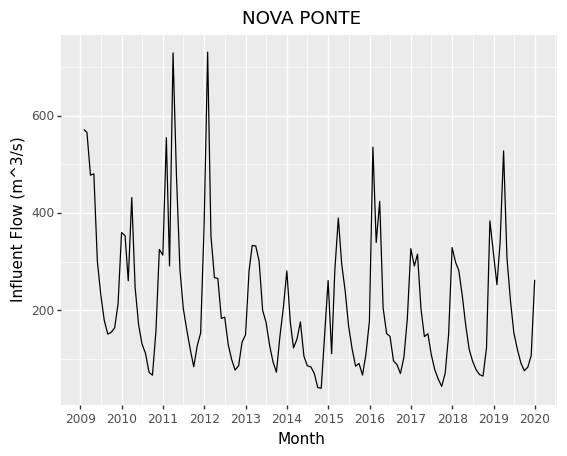

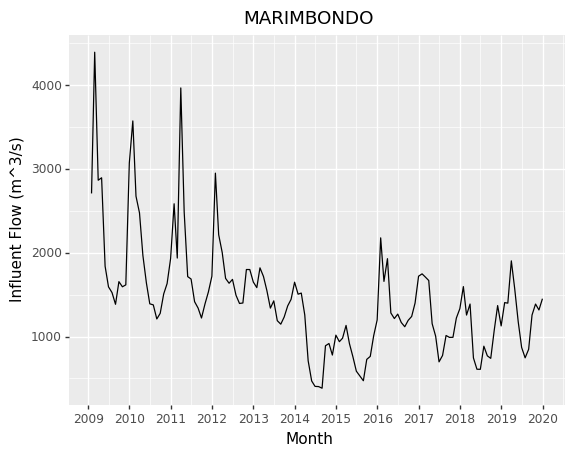

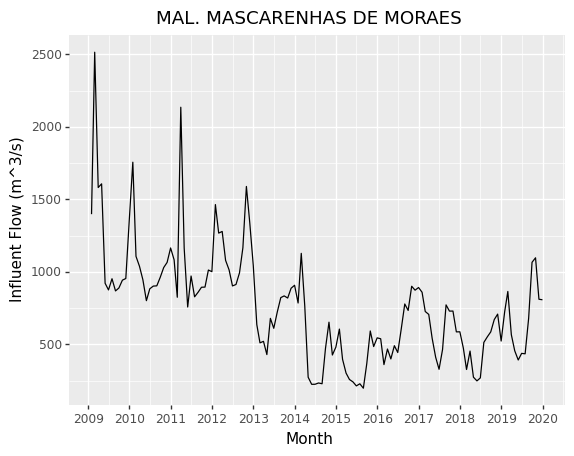

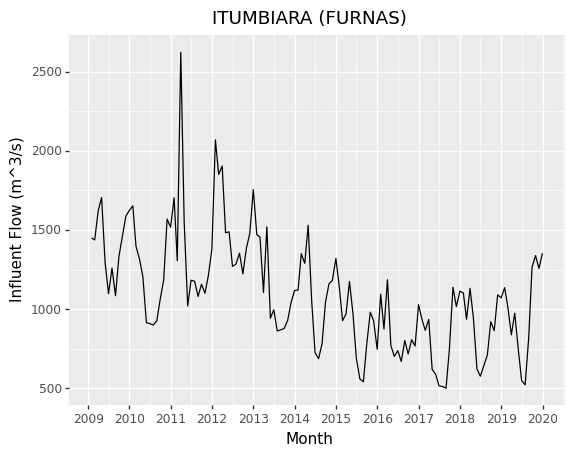

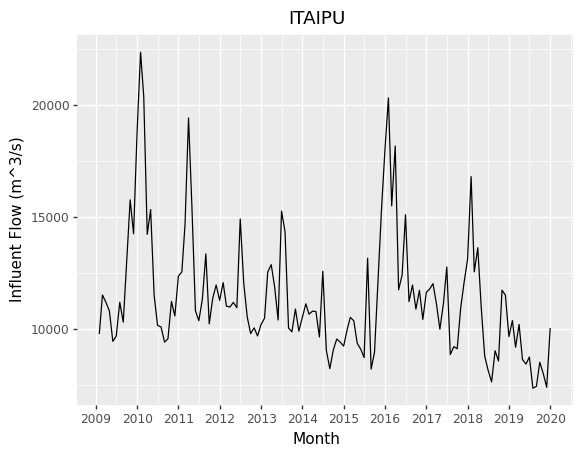

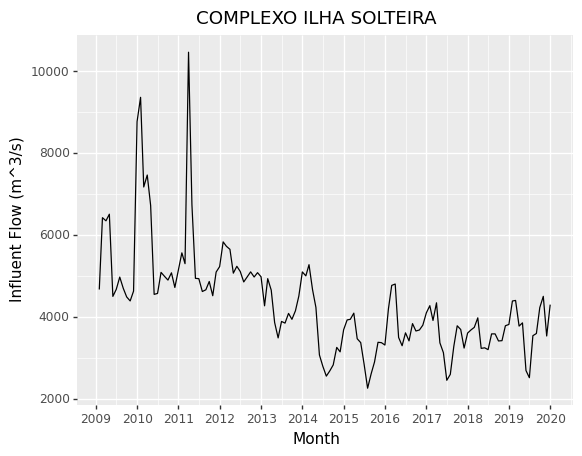

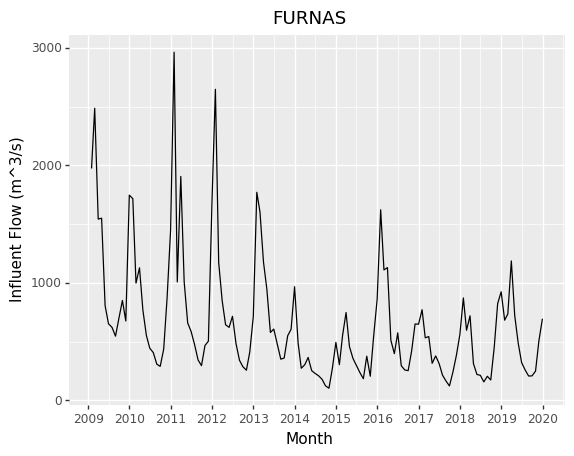

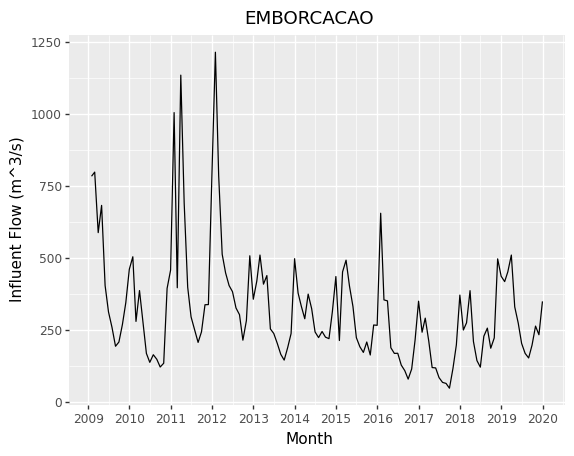

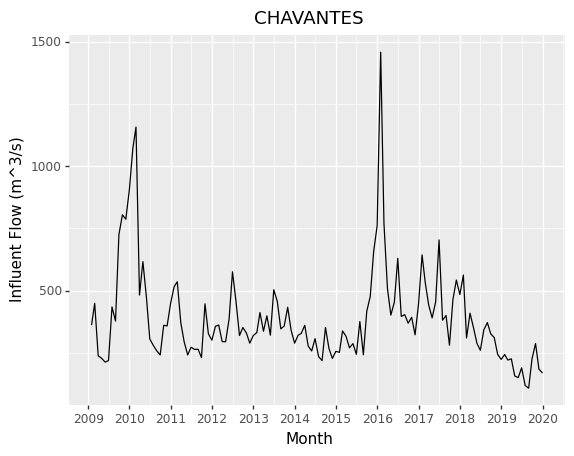

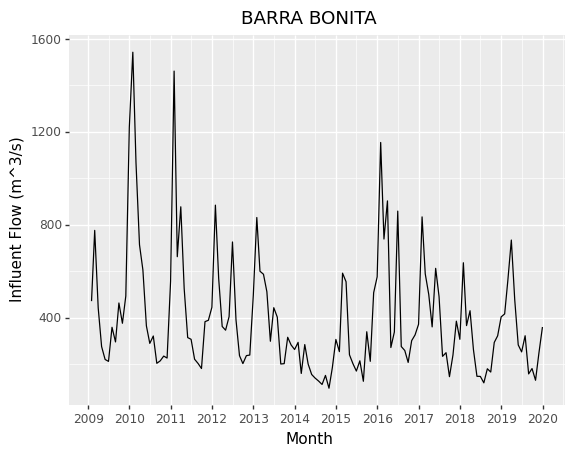

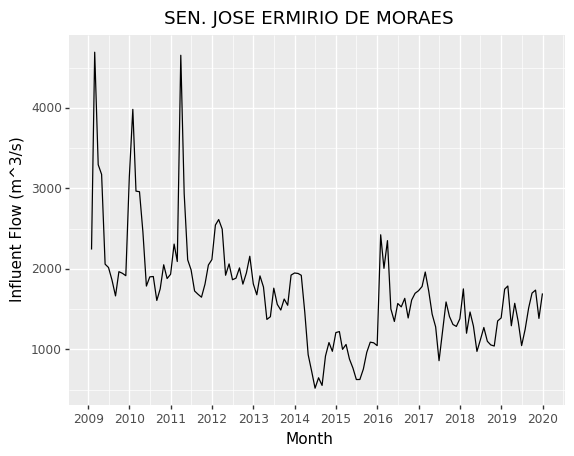

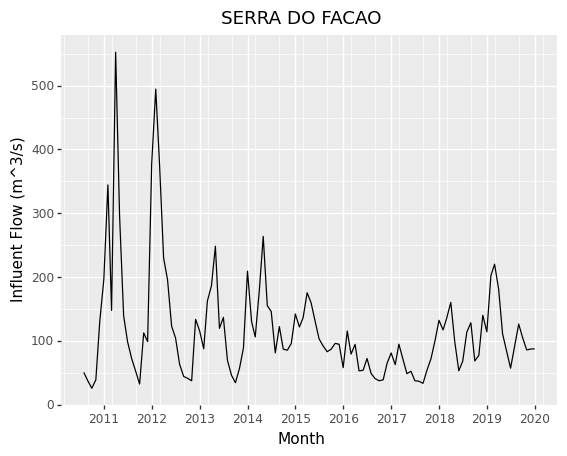

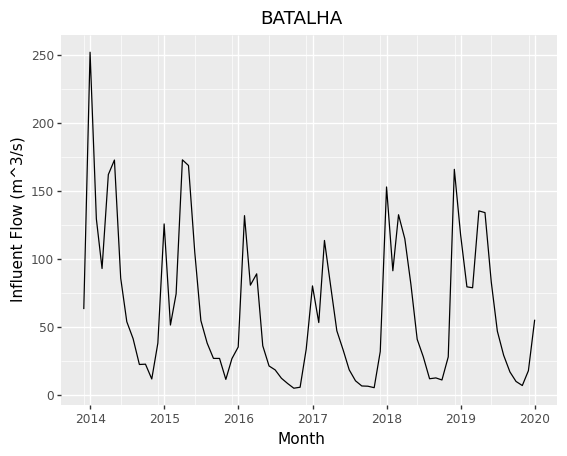

In [31]:
#Plot influent flow per dam between 2009 and 2019 for the most important ones. 
for dam in All_DF.dam.unique():
    DF=All_DF[All_DF.dam==dam].groupby(['year','month']).agg(influent_flow=('influent_flow','mean'),
                                                                        date=('date', 'max')).reset_index()
    DF=DF[(DF.year>=2009) & (DF.year<=2019)]

    G=ggplot(DF,aes(x='date',y='influent_flow', group=1))+\
    geom_line()+ggtitle(dam)+xlab('Month')+ylab('')+\
    scale_x_datetime(breaks=date_breaks('1 years'),
     labels=date_format('%Y'), minor_breaks=date_breaks('6 months'))+\
    ylab('Influent Flow (m^3/s)')
    G.draw()

## Rio Grande River

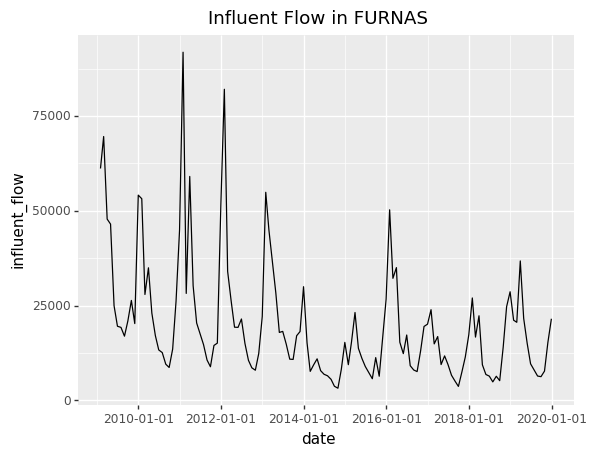

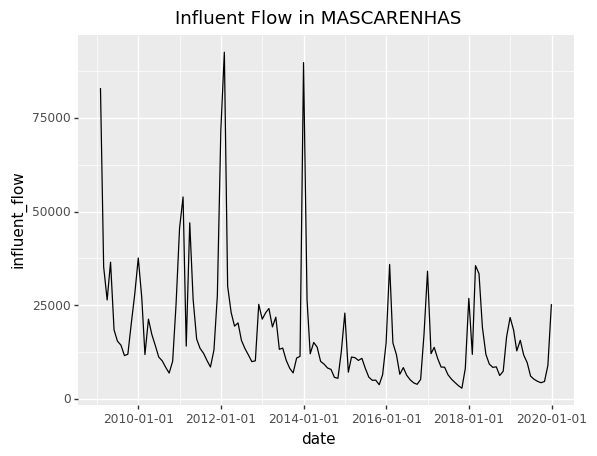

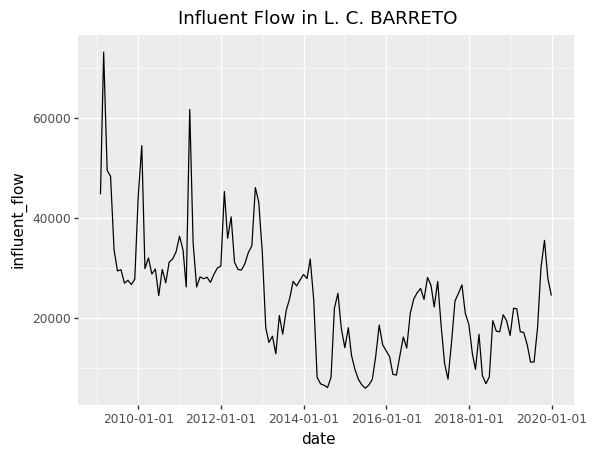

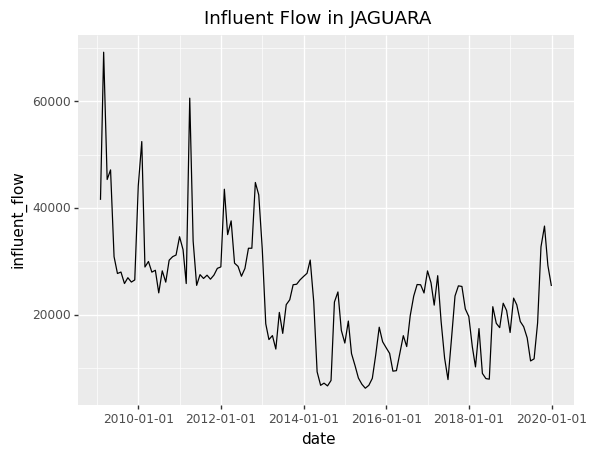

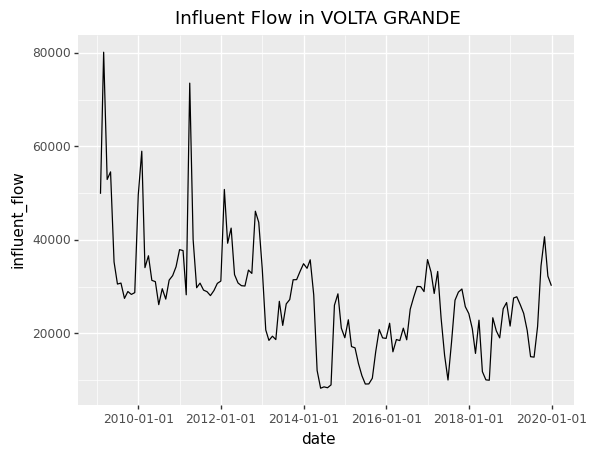

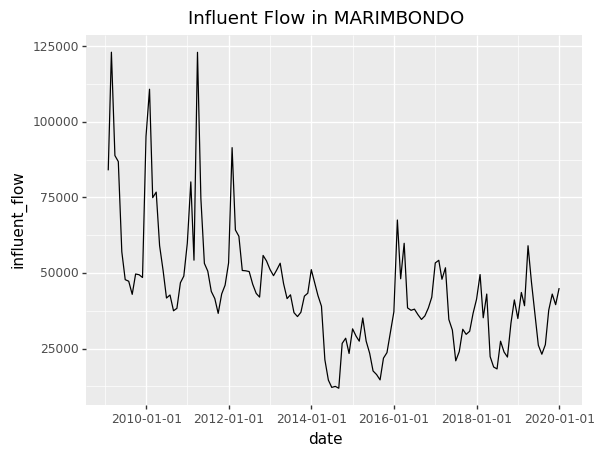

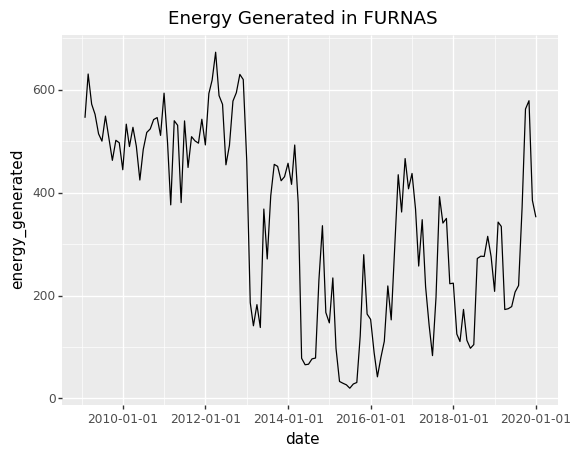

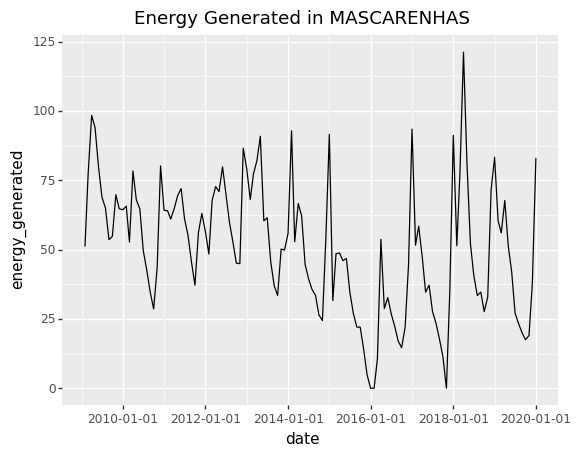

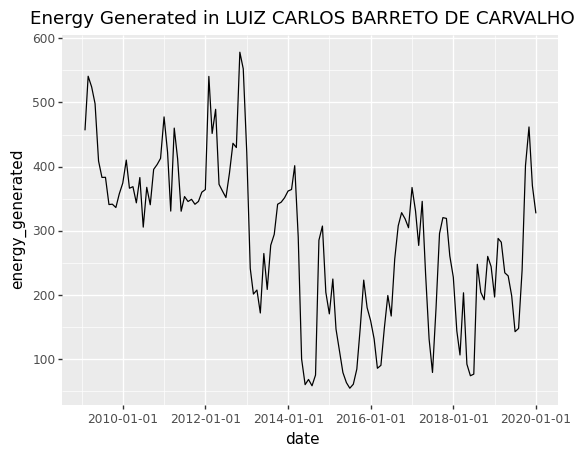

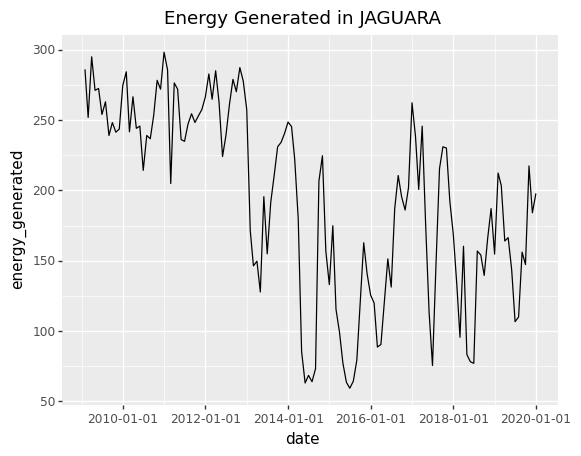

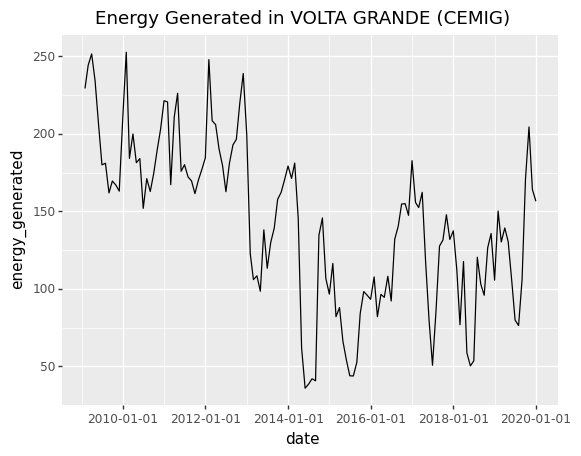

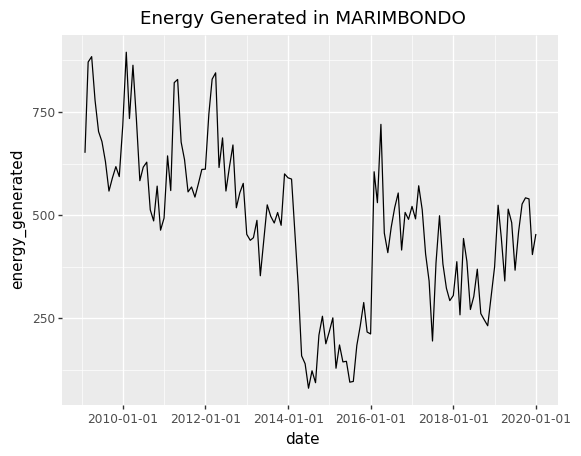

In [32]:
Rio_Grande=['FURNAS', 'MASCARENHAS', 'L. C. BARRETO', 'JAGUARA','VOLTA GRANDE','MARIMBONDO']
for dam in Rio_Grande:
    DF=DF_flow[DF_flow.dam==dam].groupby(['year','month']).agg(influent_flow=('influent_flow','sum'),
                                                                        date=('date', 'max')).reset_index()
    DF=DF[(DF.date>='2009-01-01') & (DF.date<='2019-12-31')]
    G=ggplot(DF,aes(x='date',y='influent_flow', group=1))+\
    geom_line()+ggtitle('Influent Flow in '+dam)
    
    G.draw()

Rio_Grande=['FURNAS', 'MASCARENHAS', 'LUIZ CARLOS BARRETO DE CARVALHO', 'JAGUARA','VOLTA GRANDE (CEMIG)','MARIMBONDO']
for dam in Rio_Grande:
    DF=DF_energy[DF_energy.dam==dam].groupby(['year','month']).agg(energy_generated=('energy_generated','sum'),
                                                                        date=('date', 'max')).reset_index()
    DF=DF[(DF.date>='2009-01-01') & (DF.date<='2019-12-31')]
    G=ggplot(DF,aes(x='date',y='energy_generated', group=1))+\
    geom_line()+ggtitle('Energy Generated in '+dam)
    
    G.draw()

# Random Forest per Dam Daily

In [33]:
#import functions
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
All_DF=All_DF.fillna(0)

In [34]:
for dam in All_DF.dam.unique(): 
    DF=All_DF[All_DF.dam==dam]
    X=np.c_[DF[['influent_flow', 'maximum_demand']],OneHotEncoder(sparse=False).fit_transform(DF[['month']])]
    y=np.array(DF['energy_generated'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

    RF = RandomForestRegressor(random_state = 17)
    RF.fit(X_train, y_train)

    y_pred = RF.predict(X_test)
    Importance = pd.DataFrame({'Importance':RF.feature_importances_*100}, 
                         index = ['Influent Flow', 'Maximum Demand', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep', 'Oct','Nov','Dec'])
    Importance = Importance.sort_values(by = 'Importance',ascending=False)
    mae=mean_absolute_error(y_test, y_pred)

    if Importance.index[0]=='Maximum Demand':
        print('For dam: ', dam)
        print("Random Forest MAE: %0.2f" % mae)
        print("Percentage of mean value: %0.2f %%"%(mae/np.mean(DF.energy_generated)*100))
        display(Importance.head(2))
        print('---------------------------------------------------------------------\n\n')

For dam:  TRES MARIAS
Random Forest MAE: 1.08
Percentage of mean value: 23.10 %


Importance
Maximum Demand   45.802472
Influent Flow    34.252911

---------------------------------------------------------------------


For dam:  NOVA PONTE
Random Forest MAE: 1.88
Percentage of mean value: 35.00 %


Importance
Maximum Demand   45.957445
Influent Flow    36.600042

---------------------------------------------------------------------


For dam:  FURNAS
Random Forest MAE: 4.20
Percentage of mean value: 35.55 %


Importance
Maximum Demand   44.681847
Influent Flow    36.195994

---------------------------------------------------------------------


For dam:  EMBORCACAO
Random Forest MAE: 3.29
Percentage of mean value: 34.92 %


Importance
Maximum Demand   42.963521
Influent Flow    34.346060

---------------------------------------------------------------------




In [35]:
#Combine biggest dams
#Use one influent flow aggregated. 
DF=All_DF.groupby(['month','date']).agg(influent_flow=('influent_flow','mean'),
                                        maximum_demand=('maximum_demand','sum'),
                                        energy_generated=('energy_generated','sum')).reset_index()
X=np.c_[DF[['influent_flow', 'maximum_demand']],OneHotEncoder(sparse=False).fit_transform(DF[['month']])]
y=np.array(DF['energy_generated'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

RF = RandomForestRegressor(random_state = 17)
RF.fit(X_train, y_train)

y_pred = RF.predict(X_test)
Importance = pd.DataFrame({'Importance':RF.feature_importances_*100}, 
                         index = ['influent_flow', 'maximum_demand', 
                                  'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep', 'Oct','Nov','Dec'])

Importance = Importance.sort_values(by = 'Importance',ascending=False)
mae=mean_absolute_error(y_test, y_pred)

print('FOR THE WHOLE 17 DAMS TOGETHER------------')
print("random forest MAE:", mae)
print("MAE/(mean value)*100:", np.ceil(mae/np.mean(DF.energy_generated)*100),'%')

Importance.head(2)

FOR THE WHOLE 17 DAMS TOGETHER------------
random forest MAE: 28.47329831380803
MAE/(mean value)*100: 7.0 %


Importance
influent_flow    60.238439
maximum_demand   27.277466

In [36]:
#Combine biggest dams
#Use one influent flow per dam, as different columns.
Flows=All_DF[['date', 'influent_flow','dam']].pivot(index='date',columns='dam',values='influent_flow')
name_flows=['Flow '+str(name) for name in Flows.columns]
DF=All_DF.groupby(['month','date']).agg(maximum_demand=('maximum_demand','sum'),
                                        energy_generated=('energy_generated','sum')).reset_index()

DF=DF.merge(Flows.reset_index(), on='date', how='left')

DF=DF[(DF.date>='2013-01-01') & (DF.date<='2019-12-31')]
DF=DF.fillna(0)

X=np.c_[DF.drop(['month','date','energy_generated'],axis=1),OneHotEncoder(sparse=False).fit_transform(DF[['month']])]
y=np.array(DF['energy_generated'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

RF = RandomForestRegressor()
RF.fit(X_train, y_train)

y_pred = RF.predict(X_test)
Importance = pd.DataFrame({'Importance':RF.feature_importances_*100}, 
                         index = ['maximum_demand']+name_flows+['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep', 'Oct','Nov','Dec'])
Importance = Importance.sort_values(by = 'Importance',ascending=False)
mae=mean_absolute_error(y_test, y_pred)

print('FOR THE WHOLE 17 DAMS TOGETHER (Just one level)------------')
print("random forest MAE:", mae)
print("MAE/(mean value)*100:", np.ceil(mae/np.mean(DF.energy_generated)*100),'%')

Importance.head(5)

FOR THE WHOLE 17 DAMS TOGETHER (Just one level)------------
random forest MAE: 18.66541149890248
MAE/(mean value)*100: 6.0 %


Importance
Flow SEN. JOSE ERMIRIO DE MORAES   40.981442
Flow CHAVANTES                     10.036650
Flow COMPLEXO ILHA SOLTEIRA         9.884355
maximum_demand                      6.363917
Flow ITAIPU                         5.477491

In [37]:
#Predict energy in ALL dams. 
#Use one influent flow per dam, as different columns.
Flows=All_DF[['date', 'influent_flow','dam']].pivot(index='date',columns='dam',values='influent_flow')
name_flows=['Flow '+str(name) for name in Flows.columns]

DF=DF_energy.groupby(['year','month','date']).agg(energy_generated=('energy_generated','sum')).reset_index().\
        merge(DF_Demand[['date','maximum_demand']],how='left',on='date')

DF=DF[['month','maximum_demand','date','energy_generated']].merge(Flows.reset_index(), on='date', how='left')

DF=DF[(DF.date>='2009-01-01') & (DF.date<='2019-12-31')]
DF=DF.fillna(0)

X=np.c_[DF.drop(['month','date','energy_generated'],axis=1),OneHotEncoder(sparse=False).fit_transform(DF[['month']])]
y=np.array(DF['energy_generated'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

RF = RandomForestRegressor(max_depth=3)
RF.fit(X_train, y_train)

y_pred = RF.predict(X_test)
Importance = pd.DataFrame({'Importance':RF.feature_importances_*100}, 
                         index = ['maximum_demand']+name_flows+['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep', 'Oct','Nov','Dec'])
Importance = Importance.sort_values(by = 'Importance',ascending=False)
mae=mean_absolute_error(y_test, y_pred)

print('SE/CW Subsystem (2009-2019)')
print("Random Forest MAE: %0.2f" % mae)
print("Percentage of mean value: %0.2f %%"%(mae/np.mean(DF.energy_generated)*100))
display(Importance.head(4))
print('---------------------------------------------------------------------\n\n')


SE/CW Subsystem (2009-2019)
Random Forest MAE: 39.15
Percentage of mean value: 5.56 %


Importance
Flow MARIMBONDO                    54.572920
Flow SEN. JOSE ERMIRIO DE MORAES   22.163758
maximum_demand                     18.140517
Flow SAO SIMAO (CEMIG)              1.017892

---------------------------------------------------------------------




# Random Forest per Dam Monthly

In [38]:
for dam in All_DF_monthly.dam.unique(): 
    DF=All_DF_monthly[All_DF_monthly.dam==dam]
    X=np.c_[DF[['influent_flow', 'maximum_demand']],OneHotEncoder(sparse=False).fit_transform(DF[['month']])]
    y=np.array(DF['energy_generated'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

    RF = RandomForestRegressor(random_state = 17)
    RF.fit(X_train, y_train)

    y_pred = RF.predict(X_test)
    Importance = pd.DataFrame({'Importance':RF.feature_importances_*100}, 
                         index = ['influent_flow', 'maximum_demand', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep', 'Oct','Nov','Dec'])
    Importance = Importance.sort_values(by = 'Importance',ascending=False)
    mae=mean_absolute_error(y_test, y_pred)

    print('For dam: ', dam)
    print("random forest MAE:", mae)
    print("MAE/(mean value)*100:", np.ceil(mae/np.mean(DF.energy_generated)*100),'%')
    Importance.head(2)
    print('---------------------------------------------------------------------\n\n')

For dam:  BARRA BONITA
random forest MAE: 8.545441609098987
MAE/(mean value)*100: 19.0 %
---------------------------------------------------------------------


For dam:  CHAVANTES
random forest MAE: 35.990580409717396
MAE/(mean value)*100: 25.0 %
---------------------------------------------------------------------


For dam:  COMPLEXO ILHA SOLTEIRA
random forest MAE: 96.17908188751349
MAE/(mean value)*100: 8.0 %
---------------------------------------------------------------------


For dam:  EMBORCACAO
random forest MAE: 104.61665896980882
MAE/(mean value)*100: 37.0 %
---------------------------------------------------------------------


For dam:  FURNAS
random forest MAE: 116.79263085825094
MAE/(mean value)*100: 33.0 %
---------------------------------------------------------------------


For dam:  ITAIPU
random forest MAE: 360.4346591606347
MAE/(mean value)*100: 6.0 %
---------------------------------------------------------------------


For dam:  ITUMBIARA (FURNAS)
random fore

In [39]:
#Predict energy in ALL dams (Monthly)
#Use one influent flow per dam, as different columns.
Flows=All_DF.groupby(['year','month','dam']).agg(influent_flow=('influent_flow','mean')).reset_index().\
        pivot(index=['year','month'],columns='dam',values='influent_flow').reset_index().fillna(0)
name_flows=['Flow '+str(name) for name in Flows.columns]

DF_Demand_monthly=DF_Demand.groupby(['year', 'month']).agg(maximum_demand=('maximum_demand','sum')).reset_index()

DF=DF_energy.groupby(['year','month']).agg(energy_generated=('energy_generated','sum')).reset_index().\
        merge(DF_Demand_monthly,how='left',on=['year', 'month'])

DF=DF[['month','maximum_demand','year','energy_generated']].merge(Flows.reset_index(), on=['year','month'], how='left')

DF=DF[(DF.year>=2009) & (DF.year<=2019)]
DF=DF.fillna(0)

X=np.c_[DF.drop(['month','energy_generated'],axis=1),OneHotEncoder(sparse=False).fit_transform(DF[['month']])]
y=np.array(DF['energy_generated'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

RF = RandomForestRegressor(max_depth=3)
RF.fit(X_train, y_train)

y_pred = RF.predict(X_test)
Importance = pd.DataFrame({'Importance':RF.feature_importances_*100}, 
                         index = ['maximum_demand']+name_flows+['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep', 'Oct','Nov','Dec'])
Importance = Importance.sort_values(by = 'Importance',ascending=False)
mae=mean_absolute_error(y_test, y_pred)

print('SE/CW Subsystem (2009-2019)')
print("Random Forest MAE: %0.2f" % mae)
print("Percentage of mean value: %0.2f %%"%(mae/np.mean(DF.energy_generated)*100))
display(Importance.head(4))
print('---------------------------------------------------------------------\n\n')

SE/CW Subsystem (2009-2019)
Random Forest MAE: 736.09
Percentage of mean value: 3.43 %


Importance
Flow MARIMBONDO                    44.855679
Flow SEN. JOSE ERMIRIO DE MORAES   19.198365
maximum_demand                     14.025134
Flow EMBORCACAO                     3.035169

---------------------------------------------------------------------




# Barra Bonita Graphs

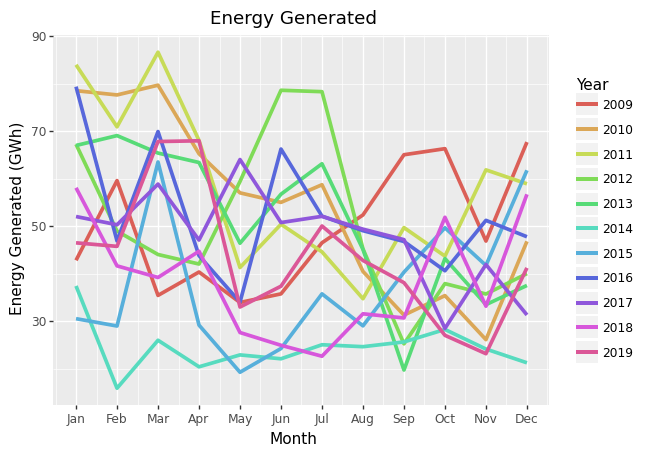

<ggplot: (91922995438)>

In [40]:
DF=DF_energy[(DF_energy.dam=='BARRA BONITA') &(DF_energy.date>='2009-01-01') & (DF_energy.date<='2019-12-31')].groupby(['year','month']).\
    agg(date=('date','min'), energy_generated=('energy_generated','sum')).reset_index()

DF['normalized_energy']=DF[['year', 'energy_generated']].\
    groupby('year',group_keys=False).apply(lambda x: x/x.max())[['energy_generated']]

ggplot(DF,aes(x='month',y='energy_generated', color='factor(year)'))+\
 geom_line(size=1.5)+ggtitle('Energy Generated')+xlab('Month')+ylab('Energy Generated (GWh)')+\
scale_x_continuous(breaks=range(1,13), 
                   labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep', 'Oct','Nov','Dec'])+\
 scale_color_discrete(name = "Year")

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
DF=All_DF[(All_DF.dam=='BARRA BONITA') & (All_DF.date>='2009-01-01') & (All_DF.date<='2019-12-31')][['log_flow', 'energy_generated']]
X=np.array(DF[['log_flow']])
y=np.array(DF['energy_generated'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

LR = LinearRegression()
LR.fit(X_train, y_train)

y_pred = LR.predict(X_test)
mae=mean_absolute_error(y_test, y_pred)
print("Linear Regression MAE: %0.2f" % mae)
print("Percentage of mean value: %0.2f %%"%(mae/np.mean(DF.energy_generated)*100))
  

Linear Regression MAE: 0.43
Percentage of mean value: 28.39 %


Correlation=  0.40446202840430395


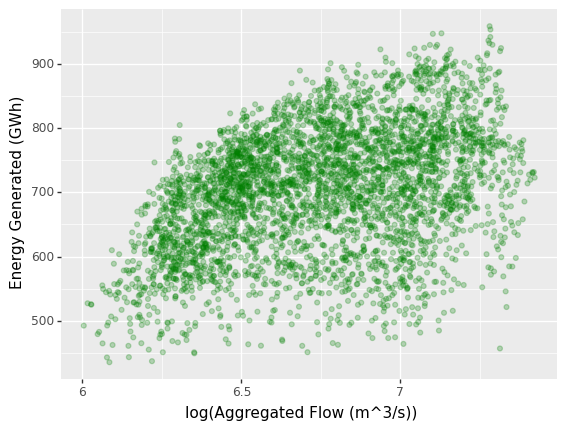

<ggplot: (91906453188)>

In [43]:
DF=DF_energy.groupby(['date']).agg(energy_generated=('energy_generated','sum')).reset_index()
DF2=DF_flow.groupby(['date']).agg(influent_flow=('influent_flow','mean')).reset_index()

DF=DF.merge(DF2,on=['date'])
DF=DF[(DF.date>='2009-01-01') & (DF.date<='2019-12-31')]
DF['log_flow']=np.log(DF.influent_flow)

print('Correlation= ', np.corrcoef(DF.log_flow,DF.energy_generated)[0,1])

ggplot(DF,aes(x='log_flow',y='energy_generated'))+\
 geom_point(alpha=0.25,color='green')+xlab('log(Aggregated Flow (m^3/s))')+ylab('Energy Generated (GWh)')


Correlation=  0.3777135360514798


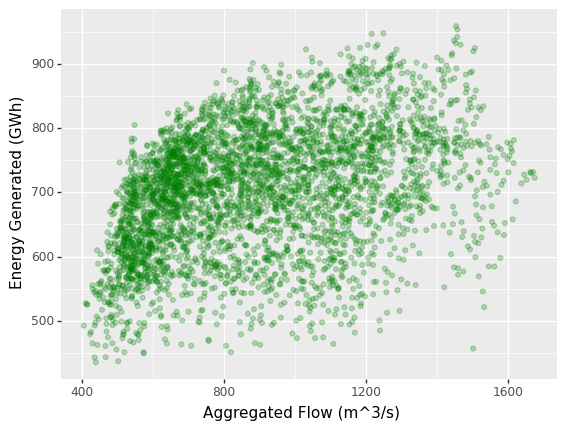

<ggplot: (91919097766)>

In [44]:
DF=DF_energy.groupby(['date']).agg(energy_generated=('energy_generated','sum')).reset_index()
DF2=DF_flow.groupby(['date']).agg(influent_flow=('influent_flow','mean')).reset_index()

DF=DF.merge(DF2,on=['date'])
DF=DF[(DF.date>='2009-01-01') & (DF.date<='2019-12-31')]
DF['log_flow']=np.log(DF.influent_flow)

print('Correlation= ', np.corrcoef(DF.influent_flow,DF.energy_generated)[0,1])

ggplot(DF,aes(x='influent_flow',y='energy_generated'))+\
 geom_point(alpha=0.25,color='green')+xlab('Aggregated Flow (m^3/s)')+ylab('Energy Generated (GWh)')


Correlation=  0.4810075969217169


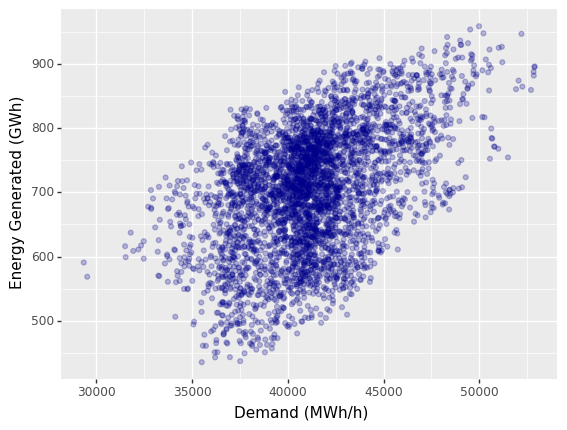

<ggplot: (91897739424)>

In [45]:
DF=DF_energy.groupby(['date']).agg(energy_generated=('energy_generated','sum')).reset_index()
DF2=DF_Demand.groupby(['date']).agg(maximum_demand=('maximum_demand','sum')).reset_index()

DF=DF.merge(DF2,on=['date'])
DF=DF[(DF.date>='2009-01-01') & (DF.date<='2019-12-31')]

print('Correlation= ', np.corrcoef(DF.maximum_demand,DF.energy_generated)[0,1])

ggplot(DF,aes(x='maximum_demand',y='energy_generated'))+\
 geom_point(alpha=0.25,color='darkblue')+xlab('Demand (MWh/h)')+ylab('Energy Generated (GWh)')

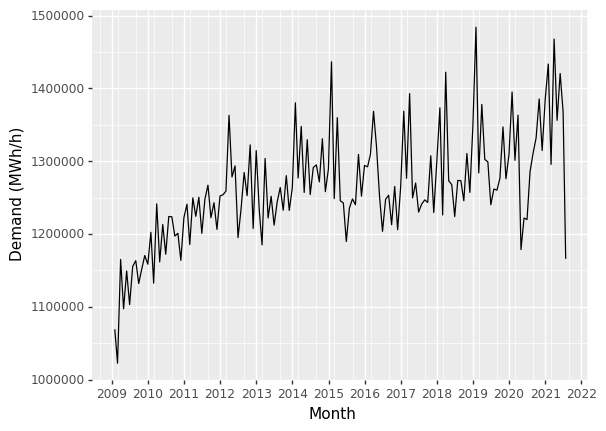

<ggplot: (91904873388)>

In [46]:
DF=DF_Demand.groupby(['year','month']).agg(maximum_demand=('maximum_demand','sum'),
                                                                    date=('date', 'max')).reset_index()
DF=DF[(DF.year>=2009) & (DF.year<=2021)]

ggplot(DF,aes(x='date',y='maximum_demand', group=1))+\
geom_line()+xlab('Month')+ylab('')+\
scale_x_datetime(breaks=date_breaks('1 years'),
 labels=date_format('%Y'), minor_breaks=date_breaks('6 months'))+\
ylab('Demand (MWh/h)')